# Empirical Illustration

This notebook contains the code and demonstration to reproduce the empirical results in the paper. Required packages can be found below. 

- Julia v1.6.2 with the following default packages
   1. LinearAlgebra
   2. Optim
   3. Statistics
   4. Dates
- External Packages
    1. [CSV](https://csv.juliadata.org/stable/) v0.8.5
    2. [DataFrames](https://dataframes.juliadata.org/stable/) v1.2.2 
    3. [Distributions](https://juliastats.org/Distributions.jl/stable) v0.24.18
    4. [Optim](https://julianlsolvers.github.io/Optim.jl/stable/) v1.4.1
    5. [Kronecker](https://github.com/MichielStock/Kronecker.jl) v0.4.4
    6. [HypothesisTests](https://juliastats.org/HypothesisTests.jl/stable/) v0.10.4
    7. [StatsPlots](https://github.com/JuliaPlots/StatsPlots.jl) v0.14.26
    8. [PrettyTables](https://www.juliapackages.com/p/prettytables) v1.1.0

The boolean variable *savegraph* is used to control if the plot should be saved as external files. If true, execution of the notebook will produce external PDF files for the plots. 

### Necessary packages

In [1]:
using LinearAlgebra
using Distributions
using Kronecker
using Optim
using Statistics
using CSV
using DataFrames
using HypothesisTests
using Plots
using LaTeXStrings
using Dates
using StatsPlots
using PrettyTables

### Load Datasets

In [4]:
Data_infl = DataFrame(CSV.File("../../data/empirical/InflationData.csv"))
Data_grow = DataFrame(CSV.File("../../data/empirical/GrowthData.csv"))
Data_unem = DataFrame(CSV.File("../../data/empirical/UnempData.csv"))
y_infl = Data_infl[:,6] #Data["actual"]
y_grow = Data_grow[:,6] #Data["actual"]
y_unem = Data_unem[:,6] #Data["actual"]
Z_infl = hcat(Data_infl[:,2],Data_infl[:,3],Data_infl[:,4],Data_infl[:,5]);
Z_grow = hcat(Data_grow[:,2],Data_grow[:,3],Data_grow[:,4],Data_grow[:,5]);
Z_unem = hcat(Data_unem[:,2],Data_unem[:,3],Data_unem[:,4],Data_unem[:,5]);

### Figure 6: Forecasters and economic indicators

#### INFLATION RATE

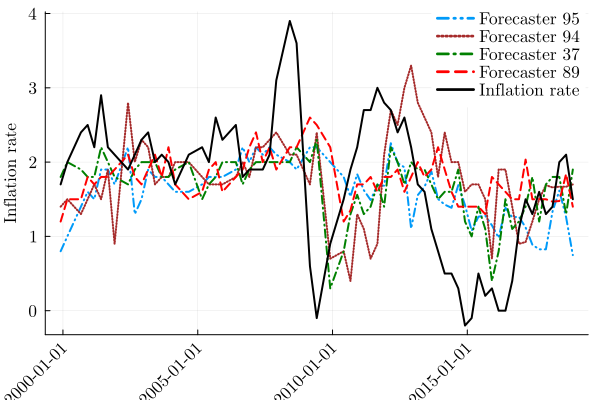

In [9]:
plot(Data_infl[:,1],Data_infl[:,2],labels = "Forecaster 95",style=:dashdotdot, linewidth = [2 1 1])
plot!(Data_infl[:,1],Data_infl[:,3],labels= "Forecaster 94",style=:dot, color=:brown, linewidth = [2 1 1])
plot!(Data_infl[:,1],Data_infl[:,4],labels= "Forecaster 37",style=:dashdot, color=:green, linewidth = [2 1 1])
plot!(Data_infl[:,1],Data_infl[:,5],labels= "Forecaster 89",style=:dash, color=:red, linewidth = [2 1 1])
figure = plot!(Data_infl[:,1],y_infl,labels= "Inflation rate", color=:black,xrotation = 45,xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=(0.8, 0.98),fg_legend = :transparent,linewidth = [2 1 1], legendfont = font("Computer Modern",11))
#xaxis!("Year", font("Computer Modern",11))
yaxis!("Inflation rate", font("Computer Modern",11))
#savefig(figure, "figure_inflation.pdf")

#### GROWTH RATE

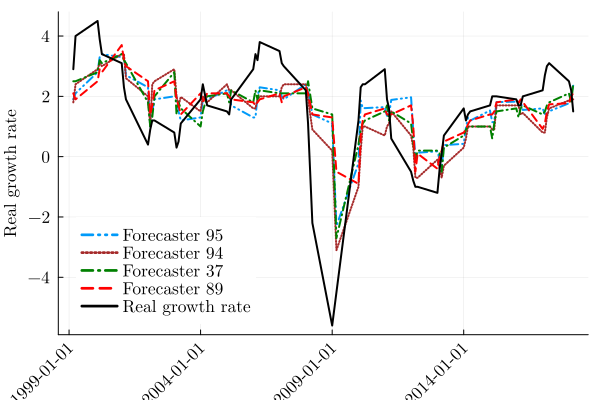

In [6]:
plot(Data_grow[:,1],Data_grow[:,2],labels = "Forecaster 95",style=:dashdotdot, linewidth = [2 1 1])
plot!(Data_grow[:,1],Data_grow[:,3],labels= "Forecaster 94",style=:dot, color=:brown, linewidth = [2 1 1])
plot!(Data_grow[:,1],Data_grow[:,4],labels= "Forecaster 37",style=:dashdot, color=:green, linewidth = [2 1 1])
plot!(Data_grow[:,1],Data_grow[:,5],labels= "Forecaster 89",style=:dash, color=:red, linewidth = [2 1 1])
figure = plot!(Data_grow[:,1],Data_grow[:,6],labels= "Real growth rate", color=:black,xrotation = 45,xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:bottomleft,fg_legend = :transparent,linewidth = [2 1 1], legendfont = font("Computer Modern",11))
#xaxis!("Year", font("Computer Modern",11))
yaxis!("Real growth rate", font("Computer Modern",11))
#savefig(figure, "figure_growth.pdf")

#### UNEMPLOYMENT RATE

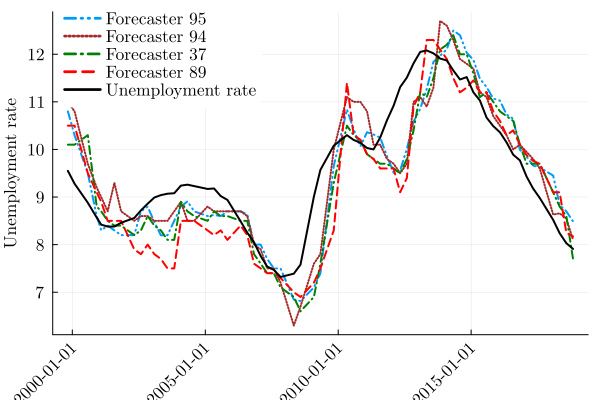

In [7]:
plot(Data_unem[:,1],Data_unem[:,2],labels = "Forecaster 95",style=:dashdotdot, linewidth = [2 1 1])
plot!(Data_unem[:,1],Data_unem[:,3],labels= "Forecaster 94",style=:dot, color=:brown, linewidth = [2 1 1])
plot!(Data_unem[:,1],Data_unem[:,4],labels= "Forecaster 37",style=:dashdot, color=:green, linewidth = [2 1 1])
plot!(Data_unem[:,1],Data_unem[:,5],labels= "Forecaster 89",style=:dash, color=:red, linewidth = [2 1 1])
figure = plot!(Data_unem[:,1],Data_unem[:,6],labels= "Unemployment rate", color=:black,xrotation = 45,xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),fg_legend = :transparent,legend=(0.1, 0.98),linewidth = [2 1 1], legendfont = font("Computer Modern",11))
#xaxis!("Year", font("Computer Modern",11))
yaxis!("Unemployment rate", font("Computer Modern",11))
#savefig(figure, "figure_unemp.pdf")

## Empirical Analysis

#### MAE LOSS FUNCTION

In [10]:
function maeloss(a_init,nu_it)
    (T,p) = size(nu_it)
    a = zeros(p,1)
    a[1:p-1,1] = a_init
    a[p,1] = 1 - sum(a_init)
    nu_c = nu_it*a
    mae = sum(abs.(nu_c))/T
    return mae
end

maeloss (generic function with 1 method)

#### EXPANDING WINDOW FUNCTION

In [11]:
function expandingwindow(y,Z)
    (T,p) = size(Z)
    T2 = Int.(collect(floor(T/2):T))
    a_MSE = zeros(length(T2),p)
    a_MAE = zeros(length(T2),p)
    for i = 1:length(T2)
            t = T2[i]
            errors = (y[1:t,:].*ones(t,p))-Z[1:t,:]
            #MSE weights 
            Omegahat = cov(errors);
            a_MSE[i,:] = Omegahat\ones(p,1)/(ones(p,1)'/Omegahat*ones(p,1))
    
            #MAE weights
            a_init = Omegahat\ones(p,1)/(ones(p,1)'/Omegahat*ones(p,1))
            sln = optimize(a_mae->maeloss(a_mae, errors), a_init[1:p-1,1],BFGS()) 
            a_mae_raw = Optim.minimizer(sln)
            a_MAE[i,:] = [a_mae_raw;1-sum(a_mae_raw)]   
    end
    return a_MSE, a_MAE
end

expandingwindow (generic function with 1 method)

### Estimating MSE and MAE Optimal Weights

In [12]:
(a_MSE_infl, a_MAE_infl) = expandingwindow(y_infl,Z_infl);
(a_MSE_grow, a_MAE_grow) = expandingwindow(y_grow,Z_grow);
(a_MSE_unem, a_MAE_unem) = expandingwindow(y_unem,Z_unem);

### Table 1: Sample kurtosis & Jarque-Bera normality tests for forecast errors

#### TABLE 1 ANALYTICS FUNCTION

In [13]:
function table1(y,Z)
    (T,p) = size(Z)
    ferrors = y.*ones(T,p) - Z
    
    errors_kurt = zeros(p,1)
    errors_skew = zeros(p,1)
    jbpval = zeros(p,1);
    for i = 1:p
        errors_kurt[i] = 3+kurtosis(ferrors[:,i])
        errors_skew[i] = skewness(ferrors[:,i])
        jbpval[i] = pvalue(JarqueBeraTest(ferrors[:,i]))
        
    end
    return errors_kurt, errors_skew, jbpval
end

table1 (generic function with 1 method)

In [14]:
(kurt_infl, skew_infl, jbpval_infl) = table1(y_infl,Z_infl)
(kurt_grow, skew_grow, jbpval_grow) = table1(y_grow,Z_grow)
(kurt_unem, skew_unem, jbpval_unem) = table1(y_unem,Z_unem);

In [15]:
DF1 = DataFrame(Macro_Indicator = ["Inflation", "","", "Growth", "","", "Unemployment", ""], 
   Statistic = ["Kurtosis","JB p-value","","Kurtosis","JB p-value","","Kurtosis","JB p-value"],
    fcast95 = [kurt_infl[1], jbpval_infl[1],"",kurt_grow[1], jbpval_grow[1],"",kurt_unem[1], jbpval_unem[1]],
    fcast94 = [kurt_infl[2], jbpval_infl[2],"",kurt_grow[2], jbpval_grow[2],"",kurt_unem[2], jbpval_unem[2]],
    fcast37 = [kurt_infl[3], jbpval_infl[3],"",kurt_grow[3], jbpval_grow[3],"",kurt_unem[3], jbpval_unem[3]],
    fcast89 = [kurt_infl[4], jbpval_infl[4],"",kurt_grow[4], jbpval_grow[4],"",kurt_unem[4], jbpval_unem[4]])
pretty_table(DF1, nosubheader=true)

┌─────────────────┬────────────┬─────────────┬────────────┬─────────────┬─────────────┐
│ Macro_Indicator │  Statistic │     fcast95 │    fcast94 │     fcast37 │     fcast89 │
├─────────────────┼────────────┼─────────────┼────────────┼─────────────┼─────────────┤
│       Inflation │   Kurtosis │     2.85663 │    2.60603 │     3.44566 │     2.78024 │
│                 │ JB p-value │    0.151345 │   0.619076 │    0.220616 │     0.11434 │
│                 │            │             │            │             │             │
│          Growth │   Kurtosis │     9.31855 │    6.84555 │     11.3375 │     8.45171 │
│                 │ JB p-value │ 3.15076e-34 │ 1.3852e-14 │ 1.33413e-56 │ 6.29587e-27 │
│                 │            │             │            │             │             │
│    Unemployment │   Kurtosis │     3.33165 │    3.02889 │     3.24416 │     2.71472 │
│                 │ JB p-value │   0.0266102 │   0.223353 │     0.10063 │    0.165599 │
└─────────────────┴────────────┴

### Table 2: Forecast combination evaluation

#### TABLE 2 ANALYTICS FUNCTION

In [16]:
function table2(y,Z,a_MSE,a_MAE)
    (T,p) = size(Z)
    T2 = Int.(collect(floor(T/2):T))
    errors_wmse = y[T2[1]+1:end,:] - sum(a_MSE[1:end-1,:].*Z[T2[1]+1:end,:],dims=2)
    errors_wmae = y[T2[1]+1:end,:] - sum(a_MAE[1:end-1,:].*Z[T2[1]+1:end,:],dims=2)
    Npred = size(errors_wmse,1);
    MSFE = [sum(errors_wmse.^2,dims=1)/Npred;sum(errors_wmae.^2,dims=1)/Npred]
    MAFE = [sum(abs.(errors_wmse),dims=1)/Npred;sum(abs.(errors_wmae),dims=1)/Npred]
    return MSFE, MAFE
end

table2 (generic function with 1 method)

In [17]:
(MSFE_infl, MAFE_infl) = table2(y_infl,Z_infl,a_MSE_infl,a_MAE_infl)
(MSFE_grow, MAFE_grow) = table2(y_grow,Z_grow,a_MSE_grow,a_MAE_grow)
(MSFE_unem, MAFE_unem) = table2(y_unem,Z_unem,a_MSE_unem,a_MAE_unem);

In [18]:
DF2 = DataFrame(Macro_Indicator = ["Inflation", "","", "Growth", "","", "Unemployment", ""], 
   Weights = ["MSE","MAE","","MSE","MAE","","MSE","MAE"],
    MSFE = [MSFE_infl[1], MSFE_infl[2],"",MSFE_grow[1], MSFE_grow[2],"",MSFE_unem[1], MSFE_unem[2]],
    MAFE = [MAFE_infl[1], MAFE_infl[2],"",MAFE_grow[1], MAFE_grow[2],"",MAFE_unem[1], MAFE_unem[2]])
pretty_table(DF2, nosubheader=true)

┌─────────────────┬─────────┬──────────┬──────────┐
│ Macro_Indicator │ Weights │     MSFE │     MAFE │
├─────────────────┼─────────┼──────────┼──────────┤
│       Inflation │     MSE │ 0.690507 │ 0.667301 │
│                 │     MAE │ 0.705157 │ 0.704742 │
│                 │         │          │          │
│          Growth │     MSE │  1.40369 │  1.01255 │
│                 │     MAE │  1.01314 │ 0.837337 │
│                 │         │          │          │
│    Unemployment │     MSE │ 0.528022 │ 0.582484 │
│                 │     MAE │ 0.676405 │ 0.680535 │
└─────────────────┴─────────┴──────────┴──────────┘


### Figure 7: Q-Q plots of individual forecast errors

#### INFLATION RATE

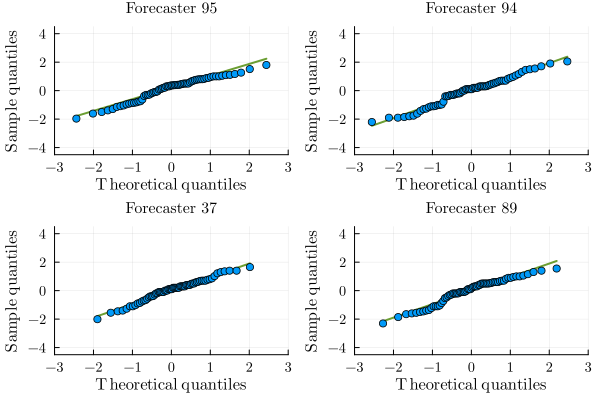

In [19]:
plot(qqplot(Normal(0,1),Data_infl[:,6]-Data_infl[:,2],title="Forecaster 95", titlefont=font("Computer Modern",10), qqline=:R),
     qqnorm(Data_infl[:,6]-Data_infl[:,3],title="Forecaster 94",titlefont=font("Computer Modern",10), qqline=:fit),
     qqnorm(Data_infl[:,6]-Data_infl[:,4],title="Forecaster 37",titlefont=font("Computer Modern",10), qqline=:fit),
     qqnorm(Data_infl[:,6]-Data_infl[:,5],title="Forecaster 89",titlefont=font("Computer Modern",10), qqline=:fit),
    xlabel=L"\textrm{Theoretical \; quantiles}",xlabelfont =font("Computer Modern",9), ylabel = L"\textrm{Sample \; quantiles}", label="", xtickfont=font("Computer Modern",9),ytickfont=font("Computer Modern",9),
    legend=:bottomleft,fg_legend = :transparent,linewidth = [2 2 2], legendfont = font("Computer Modern",9) )
figure = xaxis!(xlims=(-3,3),ylims=(-4.5,4.5))
#savefig(figure, "qq_inflation.pdf")

#### GROWTH RATE

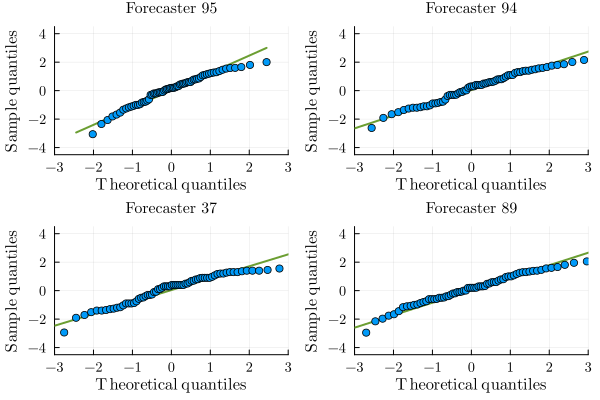

In [20]:
plot(qqplot(Normal(0,1),Data_grow[:,6]-Data_grow[:,2],title="Forecaster 95", titlefont=font("Computer Modern",10), qqline=:R),
     qqnorm(Data_grow[:,6]-Data_grow[:,3],title="Forecaster 94",titlefont=font("Computer Modern",10), qqline=:fit),
     qqnorm(Data_grow[:,6]-Data_grow[:,4],title="Forecaster 37",titlefont=font("Computer Modern",10), qqline=:fit),
     qqnorm(Data_grow[:,6]-Data_grow[:,5],title="Forecaster 89",titlefont=font("Computer Modern",10), qqline=:fit),
    xlabel=L"\textrm{Theoretical \; quantiles}",xlabelfont =font("Computer Modern",9), ylabel = L"\textrm{Sample \; quantiles}", label="", xtickfont=font("Computer Modern",9),ytickfont=font("Computer Modern",9),
    legend=:bottomleft,fg_legend = :transparent,linewidth = [2 2 2], legendfont = font("Computer Modern",9) )
figure = xaxis!(xlims=(-3,3),ylims=(-4.5,4.5))
#savefig(figure, "qq_growth.pdf")

#### UNEMPLOYMENT RATE

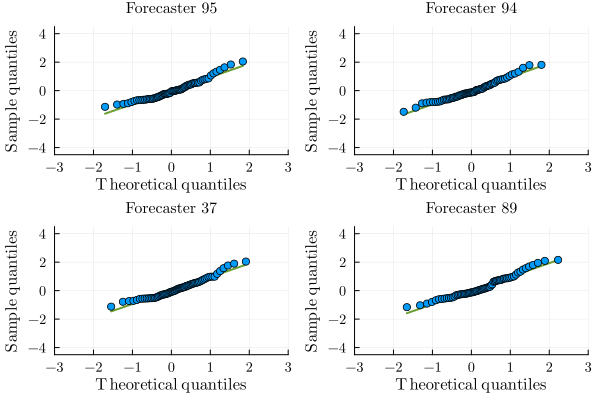

In [21]:
plot(qqnorm(Data_unem[:,6]-Data_unem[:,2],title="Forecaster 95", titlefont=font("Computer Modern",10), qqline=:fit),
     qqnorm(Data_unem[:,6]-Data_unem[:,3],title="Forecaster 94",titlefont=font("Computer Modern",10), qqline=:fit),
     qqnorm(Data_unem[:,6]-Data_unem[:,4],title="Forecaster 37",titlefont=font("Computer Modern",10), qqline=:fit),
     qqnorm(Data_unem[:,6]-Data_unem[:,5],title="Forecaster 89",titlefont=font("Computer Modern",10), qqline=:fit),
    xlabel=L"\textrm{Theoretical \; quantiles}",xlabelfont =font("Computer Modern",9), ylabel = L"\textrm{Sample \; quantiles}", label="", xtickfont=font("Computer Modern",9),ytickfont=font("Computer Modern",9),
    legend=:bottomleft,fg_legend = :transparent,linewidth = [2 2 2], legendfont = font("Computer Modern",9) )
figure = xaxis!(xlims=(-3,3),ylims=(-4.5,4.5))
#savefig(figure, "qq_unemp.pdf")

### Figure 8: Difference between MAE and MSE forecast combination weights

#### INFLATION RATE

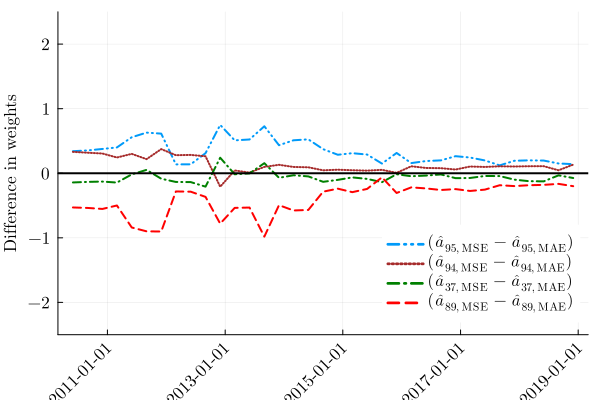

In [22]:
(T,p) = size(Z_infl)
T2 = Int.(collect(floor(T/2):T))
plot(Data_infl[T2,1], (a_MSE_infl[:,1]-a_MAE_infl[:,1]),labels= L"$(\hat{a}_{\textrm{95,MSE}}-\hat{a}_{\textrm{95,MAE}})$", linewidth = [2 1 1],style=:dashdotdot)
plot!(Data_infl[T2,1], (a_MSE_infl[:,2]-a_MAE_infl[:,2]),labels= L"$(\hat{a}_{\textrm{94,MSE}}-\hat{a}_{\textrm{94,MAE}})$", linewidth = [2 1 1],style=:dot, color=:brown)
plot!(Data_infl[T2,1], (a_MSE_infl[:,3]-a_MAE_infl[:,3]),labels= L"$(\hat{a}_{\textrm{37,MSE}}-\hat{a}_{\textrm{37,MAE}})$", linewidth = [2 1 1],style=:dashdot, color=:green)
plot!(Data_infl[T2,1], (a_MSE_infl[:,4]-a_MAE_infl[:,4]),labels= L"$(\hat{a}_{\textrm{89,MSE}}-\hat{a}_{\textrm{89,MAE}})$", linewidth = [2 1 1],style=:dash, color=:red)
figure = hline!([0],label = "", color=:black, xrotation = 45,xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=(0.7, 0.28),fg_legend = :transparent, ylims=(-2.5,2.5),linewidth = [2 1 1], legendfont = font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_inflationweight.pdf")

#### GROWTH RATE

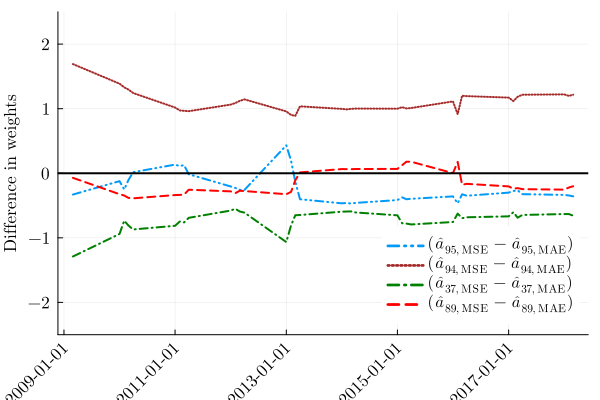

In [23]:
(T,p) = size(Z_grow)
T2 = Int.(collect(floor(T/2):T))
plot(Data_grow[T2,1], (a_MSE_grow[:,1]-a_MAE_grow[:,1]),labels= L"$(\hat{a}_{\textrm{95,MSE}}-\hat{a}_{\textrm{95,MAE}})$", linewidth = [2 1 1],style=:dashdotdot)
plot!(Data_grow[T2,1], (a_MSE_grow[:,2]-a_MAE_grow[:,2]),labels= L"$(\hat{a}_{\textrm{94,MSE}}-\hat{a}_{\textrm{94,MAE}})$", linewidth = [2 1 1],style=:dot, color=:brown)
plot!(Data_grow[T2,1], (a_MSE_grow[:,3]-a_MAE_grow[:,3]),labels= L"$(\hat{a}_{\textrm{37,MSE}}-\hat{a}_{\textrm{37,MAE}})$", linewidth = [2 1 1],style=:dashdot, color=:green)
plot!(Data_grow[T2,1], (a_MSE_grow[:,4]-a_MAE_grow[:,4]),labels= L"$(\hat{a}_{\textrm{89,MSE}}-\hat{a}_{\textrm{89,MAE}})$", linewidth = [2 1 1],style=:dash, color=:red)
figure = hline!([0],label = "", color=:black, xrotation = 45,xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=(0.7, 0.275),fg_legend = :transparent, ylims=(-2.5,2.5),linewidth = [2 1 1], legendfont = font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_growthweight.pdf")

#### UNEMPLOYMENT RATE

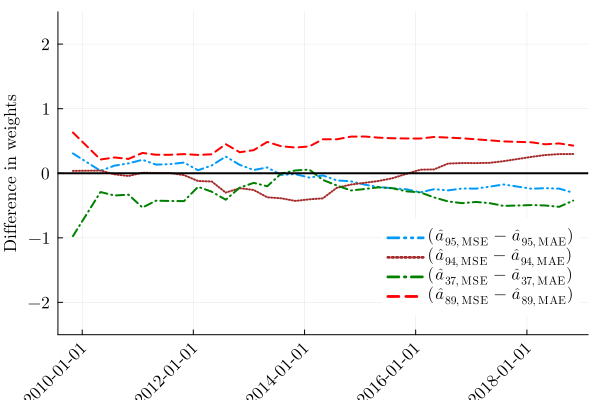

In [24]:
(T,p) = size(Z_unem)
T2 = Int.(collect(floor(T/2):T))
plot(Data_unem[T2,1], (a_MSE_unem[:,1]-a_MAE_unem[:,1]),labels= L"$(\hat{a}_{\textrm{95,MSE}}-\hat{a}_{\textrm{95,MAE}})$", linewidth = [2 1 1], style=:dashdotdot)
plot!(Data_unem[T2,1], (a_MSE_unem[:,2]-a_MAE_unem[:,2]),labels= L"$(\hat{a}_{\textrm{94,MSE}}-\hat{a}_{\textrm{94,MAE}})$", linewidth = [2 1 1],style=:dot, color=:brown)
plot!(Data_unem[T2,1], (a_MSE_unem[:,3]-a_MAE_unem[:,3]),labels= L"$(\hat{a}_{\textrm{37,MSE}}-\hat{a}_{\textrm{37,MAE}})$", linewidth = [2 1 1],style=:dashdot, color=:green)
figure = plot!(Data_unem[T2,1], (a_MSE_unem[:,4]-a_MAE_unem[:,4]),labels= L"$(\hat{a}_{\textrm{89,MSE}}-\hat{a}_{\textrm{89,MAE}})$", linewidth = [2 1 1],style=:dash, color=:red)
hline!([0],label = "", color=:black, xrotation = 45,xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=(0.7, 0.3),fg_legend = :transparent, ylims=(-2.5,2.5),linewidth = [2 1 1], legendfont = font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_unempweight.pdf")